- Applying **Dropout** to modebl by tf.contrib.rnn.DropoutWrapper
- Applying **Stacking** to model by tf.contrib.rnn.MultiRNNCell

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string
%matplotlib inline

slim = tf.contrib.slim
print(tf.__version__)

Instructions for updating:
Use the retry module or similar alternatives.
1.7.0


In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1.,0.], [0.,1.], [1.,0.], [1., 0.],[0.,1.], [1.,0.]]

In [3]:
# Character quantization
char_space = string.ascii_lowercase 
char_space = char_space + ' ' + '*'
char_space

'abcdefghijklmnopqrstuvwxyz *'

In [4]:
char_dic = {char : idx for idx, char in enumerate(char_space)}
print(char_dic)

{'s': 18, 'h': 7, 'v': 21, 'u': 20, 'g': 6, 'p': 15, 'b': 1, 'm': 12, 't': 19, 'i': 8, 'o': 14, 'y': 24, ' ': 26, '*': 27, 'r': 17, 'l': 11, 'w': 22, 'x': 23, 'j': 9, 'a': 0, 'q': 16, 'f': 5, 'c': 2, 'z': 25, 'd': 3, 'e': 4, 'n': 13, 'k': 10}


In [5]:
def pad_seq(sequences, max_len, dic):
    seq_len, seq_indices = [], []
    for seq in sequences:
        seq_len.append(len(seq))
        seq_idx = [dic.get(char) for char in seq]
        seq_idx += (max_len - len(seq_idx)) * [dic.get('*')]
        seq_indices.append(seq_idx)
    return seq_len, seq_indices

In [6]:
max_length = 10
X_length, X_indices = pad_seq(sequences=words, max_len=max_length, dic=char_dic)

In [7]:
print(X_length)
# 순수한 리스트는 shape를 못 보여준다.
# np.shape를 쓰도록 하자.
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


In [8]:
class CharStackedRNN:
    
    def __init__(self, X_length, X_indices, y, n_of_classes, dic, hidden_dims=[32, 16]):
        
        with tf.variable_scope('rnn_input_layer'):
            # 각 단어의 길이를 나타냄
            self._X_length = X_length
            # 각 단어가 정수로 변환된 리스트
            self._X_indices = X_indices
            # 각 단어의 sentiment
            self._y = y
            self._keep_prob = tf.placeholder(dtype=tf.float32)
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot,
                                           trainable=False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            
            
        with tf.variable_scope('rnn_stacked'):
            
            cells = []
            for hidden_dim in hidden_dims:
                cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_dim,activation=tf.nn.tanh)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self._keep_prob)
                cells.append(cell)
            else:
                # MultiRNNCell은 cell의 list를 받는다.
                self.cells = tf.nn.rnn_cell.MultiRNNCell(cells=cells)
            
            self.output, self.state = tf.nn.dynamic_rnn(cell=self.cells, inputs=self._X_batch,
                                        sequence_length=self._X_length, dtype=tf.float32)
            
        with tf.variable_scope('rnn_output'):
            self._score = slim.fully_connected(inputs=self.state[-1], num_outputs = n_of_classes,
                                              activation_fn=None)
            
        with tf.variable_scope('rnn_loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('rnn_prediction'):
            self._prediction = tf.argmax(input=self._score, axis=-1, output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices, keep_prob=1.):
        feed_prediction={self._X_length:X_length, self._X_indices:X_indices, self._keep_prob:keep_prob}
        return sess.run(self._prediction, feed_dict=feed_prediction)

```python
type(char_stacked_rnn.cells)
tensorflow.python.ops.rnn_cell_impl.MultiRNNCell

char_stacked_rnn.output
<tf.Tensor 'rnn_stacked/rnn/transpose_1:0' shape=(?, 10, 16) dtype=float32>

char_stacked_rnn.state
(<tf.Tensor 'rnn_stacked/rnn/while/Exit_3:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'rnn_stacked/rnn/while/Exit_4:0' shape=(?, 16) dtype=float32>)
```

In [9]:
class CharStackedLSTM:
    
    def __init__(self, X_length, X_indices, y, n_of_classes, dic, hidden_dims=[32, 16]):
        
        with tf.variable_scope('lstm_input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            self._keep_prob = tf.placeholder(dtype=tf.float32)
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot,
                                           trainable=False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            
        with tf.variable_scope('lstm_stacked'):
            
            cells=[]
            for hidden_dim in hidden_dims:
                cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self._keep_prob)
                cells.append(cell)
            else:
                cells = tf.nn.rnn_cell.MultiRNNCell(cells=cells)
                
            _, self.states = tf.nn.dynamic_rnn(cell=cells,inputs=self._X_batch,
                                              sequence_length=self._X_length, dtype=tf.float32)
            
        with tf.variable_scope('lstm_output'):
            self._score = slim.fully_connected(inputs=self.states[-1].h, num_outputs=n_of_classes,
                                              activation_fn=None)
            
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input=self._score, axis=-1, output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices, keep_prob=1.):
        feed_prediction={self._X_length:X_length, self._X_indices:X_indices, self._keep_prob:keep_prob}
        return sess.run(self._prediction, feed_dict=feed_prediction)

```python
char_stacked_rnn.states

(LSTMStateTuple(c=<tf.Tensor 'lstm_stacked/rnn/while/Exit_3:0' shape=(?, 32) dtype=float32>, h=<tf.Tensor 'lstm_stacked/rnn/while/Exit_4:0' shape=(?, 32) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'lstm_stacked/rnn/while/Exit_5:0' shape=(?, 16) dtype=float32>, h=<tf.Tensor 'lstm_stacked/rnn/while/Exit_6:0' shape=(?, 16) dtype=float32>))
```

In [10]:
class CharStackedGRU:
    def __init__(self, X_length, X_indices, y, n_of_classes, dic, hidden_dims=[32,16]):
        
        with tf.variable_scope('gru_input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            self._keep_prob = tf.placeholder(dtype = tf.float32)
            
            one_hot = tf.eye(len(dic), dtype = tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer = one_hot,
                                            trainable = False) # embedding vector training 안할 것이기 때문
            self._X_batch = tf.nn.embedding_lookup(params = self._one_hot, ids = self._X_indices)
            
        with tf.variable_scope('gru_stacked'):
            
            cells = []
            for hidden_dim in hidden_dims:
                cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self._keep_prob)
                cells.append(cell)
            else:
                cells = tf.nn.rnn_cell.MultiRNNCell(cells=cells)
                
            _, self.state = tf.nn.dynamic_rnn(cell=cells, inputs=self._X_batch,
                                        sequence_length=self._X_length, dtype=tf.float32)
            
        with tf.variable_scope('gru_output'):
            self._score = slim.fully_connected(inputs=self.state[-1], num_outputs=n_of_classes,
                                              activation_fn=None)
            
        with tf.variable_scope('gru_loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
    def predict(self, sess, X_length, X_indices, keep_prob=1.0):
        feed_prediction={self._X_length:X_length, self._X_indices:X_indices, self._keep_prob:keep_prob}
        return sess.run(self._prediction, feed_dict=feed_prediction)

```python
char_stacked_rnn.state

(<tf.Tensor 'gru_stacked/rnn/while/Exit_3:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'gru_stacked/rnn/while/Exit_4:0' shape=(?, 16) dtype=float32>)
```

In [11]:
lr=0.003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0] / batch_size)
print(total_step)

3


In [12]:
tr_dataset = tf.data.Dataset.from_tensor_slices((X_length, X_indices, y))
tr_dataset = tr_dataset.shuffle(buffer_size=20)
tr_dataset = tr_dataset.batch(batch_size=batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

<BatchDataset shapes: ((?,), (?, 10), (?, 2)), types: (tf.int32, tf.int32, tf.float32)>


In [13]:
X_length_mb, X_indices_mb, y_mb = tr_iterator.get_next()

In [14]:
char_stacked_rnn = CharStackedGRU(X_length=X_length_mb, X_indices=X_indices_mb, y=y_mb, 
                                 n_of_classes=2,dic=char_dic)

In [16]:
opt = tf.train.AdamOptimizer(learning_rate=lr)
training_op = opt.minimize(loss=char_stacked_rnn.ce_loss)

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    sess.run(tr_iterator.initializer)
    
    try:
        while True:
            _, tr_loss = sess.run([training_op, char_stacked_rnn.ce_loss],
                                 feed_dict={char_stacked_rnn._keep_prob : 0.5})
            
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch+1, avg_tr_loss))

epoch :   1, tr_loss : 0.701
epoch :   2, tr_loss : 0.672
epoch :   3, tr_loss : 0.642
epoch :   4, tr_loss : 0.613
epoch :   5, tr_loss : 0.559
epoch :   6, tr_loss : 0.510
epoch :   7, tr_loss : 0.412
epoch :   8, tr_loss : 0.329
epoch :   9, tr_loss : 0.255
epoch :  10, tr_loss : 0.201


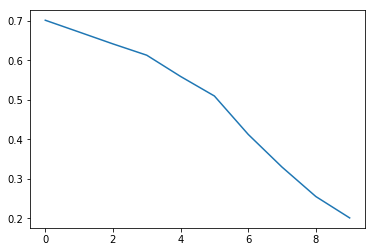

In [18]:
plt.plot(tr_loss_hist, label='train')

In [19]:
yhat = char_stacked_rnn.predict(sess=sess, X_length=X_length, X_indices=X_indices)

In [20]:
print('training acc: {:.2%}'.format(np.mean(yhat==np.argmax(y, axis=-1))))

training acc: 83.33%
